In [1]:
import pandas as pd
import numpy as np
from pyplotz.pyplotz import PyplotZ, plt
pltz = PyplotZ()
pltz.enable_chinese()

In [2]:
# Parameter
return_path = "../data/clean_data/return_20200906.csv"

In [3]:
df_ret = pd.read_csv(return_path)
df_ret["trade_date"] = pd.to_datetime(df_ret["trade_date"])
df_ret = df_ret.set_index("trade_date")
df_ret = df_ret.dropna()

In [4]:
df_ret.head()

,伊利股份,恒瑞医药,海螺水泥
trade_date,,,
2002-03-01,0.013162,0.046303,0.064124
2002-04-01,-0.034276,-0.024232,0.003611
2002-05-01,-0.059718,-0.135100,0.004944
2002-06-01,-0.024580,-0.136482,0.021925
2002-07-01,0.109498,0.014265,0.097398


# SemiDeviation

In [5]:
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

In [6]:
semideviation(df_ret).sort_values()

恒瑞医药    0.049626
海螺水泥    0.067839
伊利股份    0.081684
dtype: float64

# Historic VaR

In [7]:
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    
    Note that for reporting purposes, 
    it is common to invert the sign so we report a positive number to represent the loss 
    i.e. the amount that is at risk.
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [8]:
var_historic(df_ret, level=5).sort_values()

恒瑞医药    0.117680
伊利股份    0.146294
海螺水泥    0.160752
dtype: float64

# Conditional VaR (Beyond VaR)

In [9]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [10]:
cvar_historic(df_ret, level=5).sort_values()

恒瑞医药    0.155547
海螺水泥    0.215926
伊利股份    0.250490
dtype: float64

## Parametric Gaussian VaR

The idea behind this is very simple. If a set of returns is normally distributed, we know, for instance, that 50% of the returns are below the mean and 50% are above.

We also know that approx two thirds of the returns lie within 1 standard deviation. That means one third lie beyond one standard deviation from the mean. Since the normal distribution is symmetric, approximately one sixth (approx 16%) lie below one standard deviation away from the mean. Therefore, if we know the mean and standard deviation and if we assume that the returns are normally distributed, the 16% VaR would be the mean minus one standard deviation.

In general we can always convert a percentile point to a z-score (which is the number of standard deviations away from the mean that a number is). Therefore, if we can convert the VaR level (such as 1% or 5%) to a z-score, we can calculate the return level where that percent of returns lie below it.

`scipy.stat.norm` contains a function `ppf()` which does exactly that. It takes a percentile such as 0.05 or 0.01 and gives you the z-score corresponding to that in the normal distribution.

In [11]:
from scipy.stats import norm
def var_gaussian_old(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    return -(r.mean() + z * r.std(ddof=0))

In [13]:
var_gaussian_old(df_ret, level=5).sort_values()

恒瑞医药    0.135058
海螺水泥    0.153974
伊利股份    0.158227
dtype: float64

# Cornish-Fisher Modification

The Cornish-Fisher modification is an elegant and simple adjustment.

The z-score tells us how many standard deviations away from the mean we need to go to find the VaR. If the returns arent normal, we know that z-score will give us an inaccurate number. The basic idea is that since we can observe the skewness and kurtosis of the data, we can adjust the z-score up or down to come up with a modifed z-score. e.g. intuitively, all other things being equal, if the skewness is negative, we'll decrease the z-score further down, and if the skewness is positive, we'll push it up.

The adjusted z-score which we'll call $z_{cornishfisher}$ given by:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$


We can modify the previous function by adding a "modified" parameter with a default value of `True` as follows. If `True` then the following piece of code is executed, which modifes `z`:

```python
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
```

In [21]:
from scipy.stats import norm, skew, kurtosis

def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skew(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )

    return -(r.mean() + z*r.std(ddof=0))

In [24]:
var_gaussian(df_ret, level=5, modified=False).sort_values()

恒瑞医药    0.135058
海螺水泥    0.153974
伊利股份    0.158227
dtype: float64

In [25]:
var_gaussian(df_ret, level=5, modified=True).sort_values()

恒瑞医药    0.121896
海螺水泥    0.159442
伊利股份    0.181033
dtype: float64

# Comparison

In [39]:
var_table = [
    var_historic(df_ret),
    var_gaussian(df_ret, modified=False), 
    var_gaussian(df_ret, modified=True), 
]
df_compare = pd.concat(var_table, axis=1)
df_compare.columns = ["var_historic", "var_gaussian", "var_cornish_fisher"]
df_compare = df_compare.rename(index={"伊利股份": "Yili", "恒瑞医药": "Hengrui", "海螺水泥": "Hailuo"})

In [45]:
df_compare

,var_historic,var_gaussian,var_cornish_fisher
Yili,0.146294,0.158227,0.181033
Hengrui,0.117680,0.135058,0.121896
Hailuo,0.160752,0.153974,0.159442


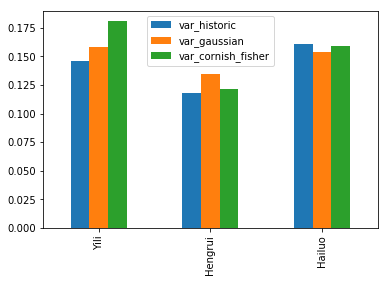

In [46]:
df_compare.plot.bar()